## This notebook analyzes the "home location" of the two players and see what player has accessed what "home" more frequently

In [0]:
import pandas as pd
import numpy as np

In [0]:
train = pd.read_csv('drive/My Drive/dacon/train.csv')
test = pd.read_csv('drive/My Drive/dacon/test.csv')

코드 공유 내용

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import warnings                             
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df_train = pd.DataFrame(train.game_id.unique(), columns=['game_id'])
df_train.index = df_train.game_id
df_train = df_train.drop(['game_id'], axis = 1)

In [0]:
# 처음 기록 된 카메라 좌표를 기록

df_train_p0 = train[(train.event=='Camera')&(train.player==0)]
df_train_p0 = df_train_p0[df_train_p0.shift(1).game_id!=df_train_p0.game_id] # 쉬프트를 이용하여 각 게임의 첫번째 데이터 찾기
df_train_p0 = df_train_p0.iloc[:, [0,6]].rename({'event_contents':'player0_starting'}, axis = 1)
df_train_p0.index = df_train_p0['game_id']
df_train_p0 = df_train_p0.drop(['game_id'], axis=1)
df_train = pd.merge(df_train, df_train_p0, on='game_id', how='left')
del df_train_p0

df_train_p1 = train[(train.event=='Camera')&(train.player==1)]
df_train_p1 = df_train_p1[df_train_p1.shift(1).game_id!=df_train_p1.game_id]
df_train_p1 = df_train_p1.iloc[:, [0,6]].rename({'event_contents':'player1_starting'}, axis = 1)
df_train_p1.index = df_train_p1['game_id']
df_train_p1 = df_train_p1.drop(['game_id'], axis=1)
df_train = pd.merge(df_train, df_train_p1, on='game_id', how='left')
del df_train_p1

In [0]:
# x, y 값으로 분리

df_train['player0_starting'] = df_train.player0_starting.str.split('(').str[1]
df_train['player0_starting'] = df_train.player0_starting.str.split(')').str[0]
split_xy = df_train.player0_starting.str.split(',')
df_train['player0_x'] = split_xy.str[0].astype('float')
df_train['player0_y'] = split_xy.str[1].astype('float')
del split_xy

df_train['player1_starting'] = df_train.player1_starting.str.split('(').str[1]
df_train['player1_starting'] = df_train.player1_starting.str.split(')').str[0]
split_xy = df_train.player1_starting.str.split(',')
df_train['player1_x'] = split_xy.str[0].astype('float')
df_train['player1_y'] = split_xy.str[1].astype('float')
del split_xy

In [0]:
# 플레이어의 x,y 좌표를 하나로 모음

location_p0 = df_train.loc[:, ['player0_x', 'player0_y']]
location_p0 = location_p0.rename({'player0_x':'location_x', 'player0_y':'location_y'}, axis=1)

location_p1 = df_train.loc[:, ['player1_x', 'player1_y']]
location_p1 = location_p1.rename({'player1_x':'location_x', 'player1_y':'location_y'}, axis=1)
location_p1.index += location_p0.index[-1]+1

location = pd.concat([location_p0, location_p1])
location = location.dropna()
del location_p0, location_p1

In [136]:
location.head()

,location_x,location_y
game_id,,
0,145.25,21.507812
1,140.00,162.007812
2,151.25,20.507812
3,127.25,27.507812
4,36.75,122.007812


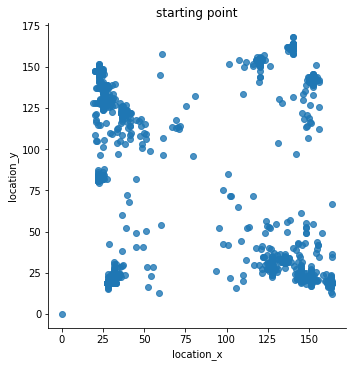

In [137]:
# 모든 포인트 시각화
sns.lmplot('location_x', 'location_y', data = location, fit_reg=False)
plt.title('starting point')
plt.show()

In [0]:
# kmeans를 이용하여 15개로 클러스터링
kmeans_clst = KMeans(n_clusters=15).fit(location)
location['starting'] = kmeans_clst.labels_+1

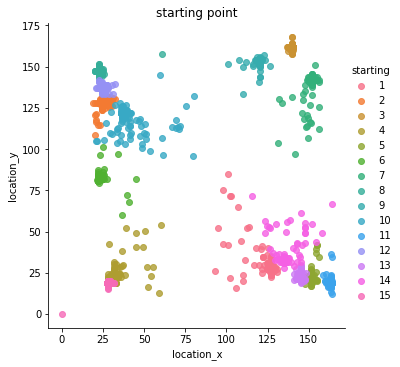

In [139]:
# 클러스트링한 결과를 시각화
sns.lmplot('location_x', 'location_y', data = location, fit_reg=False, hue="starting")
plt.title('starting point')
plt.show()

# 초반 진행 화면이 누락 된 게임은 엉뚱하게 분류 됨

In [0]:
# kmeans로 찾은 15개의 포인트에서 각 데이터들의 거리 계산
for cluster in range(15):
    point = location[location.starting==cluster+1]
    loc = point.loc[:,['location_x', 'location_y']]
    del point
    loc['center_x'] = kmeans_clst.cluster_centers_[cluster][0]
    loc['center_y'] = kmeans_clst.cluster_centers_[cluster][1]
    distance = np.sqrt(np. square(loc.location_x - loc.center_x) + np.square(loc.location_y - loc.center_y))
    location.loc[loc.index, 'distance'] = distance
    del loc

In [0]:
# 일정 거리(5)이상 떨어진 데이터는 starting을 0으로 지정
idx = location[location.distance>5].index
location.loc[idx, 'starting'] = 0
del idx

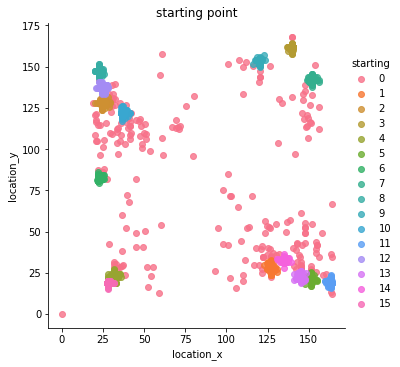

In [142]:
# 시각화를 통해 스타팅을 모르는 게임은 분홍색(0)으로 나타며 15개의 스타팅 포인트를 확인 할 수 있음.
sns.lmplot('location_x', 'location_y', data = location, fit_reg=False, hue="starting")
plt.title('starting point')
plt.show()

In [0]:
# 클러스터링한 결과 반영
df_train['player0_starting'] = location.loc[location.index.isin(df_train.index)]['starting']
location.index -= (df_train.index[-1]+1)
df_train['player1_starting'] = location.loc[location.index.isin(df_train.index)]['starting']
del location

# 불필요한 컬럼 삭제
df_train = df_train.drop(['player0_x', 'player0_y', 'player1_x', 'player1_y'], axis = 1)
df_train = df_train.fillna(0)

In [0]:
# 스타팅 포인트를 이용하여 맵 분류
map_list = []
for point in range(1,16):
    couple = df_train[df_train.player0_starting == point].player1_starting.value_counts()
    if couple[couple.index[1]]<100:
        map_list.append([point, couple.index[0], 999])
    else:
        map_list.append([point, couple.index[0], couple.index[1]])
map_list = np.sort(map_list, axis = 1)
map_list = np.unique(map_list, axis = 0)

In [0]:
# map_list와 상대편 위치 정보를 이용하여 모르는 스타팅 찾기
for m in map_list:
    idx = df_train[(df_train.player0_starting == 0)&((df_train.player1_starting == m[0])|(df_train.player1_starting == m[2]))].index
    df_train.loc[idx, 'player0_starting'] = m[1]
    del idx
    idx = df_train[(df_train.player0_starting == 0)&((df_train.player1_starting == m[1])|(df_train.player1_starting == m[2]))].index
    df_train.loc[idx, 'player0_starting'] = m[0]
    del idx
    
    idx = df_train[(df_train.player1_starting == 0)&((df_train.player0_starting == m[0])|(df_train.player0_starting == m[2]))].index
    df_train.loc[idx, 'player1_starting'] = m[1]
    del idx
    idx = df_train[(df_train.player1_starting == 0)&((df_train.player0_starting == m[1])|(df_train.player0_starting == m[2]))].index
    df_train.loc[idx, 'player1_starting'] = m[0]
    del idx

In [146]:
df_train[(df_train.player0_starting == 0)|(df_train.player1_starting == 0)].head()

,player0_starting,player1_starting
game_id,,


In [0]:
# 맵 컬럼 추가
for map_num, m in enumerate(map_list):
    idx = df_train[(df_train.player0_starting == m[0])|(df_train.player0_starting == m[1])|(df_train.player0_starting == m[2])].index
    df_train.loc[idx, 'map'] = map_num
del idx, map_list

In [151]:
df_train.head()

,player0_starting,player1_starting,map
game_id,,,
0,13.0,8.0,5.0
1,3.0,15.0,2.0
2,5.0,2.0,1.0
3,1.0,12.0,0.0
4,10.0,11.0,6.0


In [152]:
train.head()

,game_id,winner,time,player,species,event,event_contents
0,0,1,0.00,0,T,Camera,"at (145.25, 21.5078125)"
1,0,1,0.00,1,T,Camera,"at (22.75, 147.0078125)"
2,0,1,0.02,0,T,Selection,['OrbitalCommand [3080001]']
3,0,1,0.02,0,T,Ability,(1360) - TrainSCV
4,0,1,0.14,0,T,Camera,"at (142.99609375, 24.50390625)"


In [167]:
sample_prediction = kmeans_clst.predict([[22.75, 147.007]])
(sample_prediction).item(0)

7

My Part

In [0]:
# 분류된 kmeans 모델을 가지고, camera가 my starting point 또는 적의 starting point를 보는지 count
def count_looks(df, game_df, model):
  max_game_id = df.iloc[len(df)-1].game_id
  for game_id in range(0, max_game_id+1): # for every game
    zero_looks = 0 # number of times player zero looks at player one
    one_looks = 0 # number of times player one loks at player zero
    zero_home = game_df.iloc[game_id]['player0_starting'] # the home of zero
    one_home = game_df.iloc[game_id]['player1_starting']  # the home of one
    for row in df[df['game_id'] == game_id].iterrows(): # within every game
      if row[1].event == 'Camera':
        coordinate = [float(coord) for coord in  row[1].event_contents[4:-1].split(',')] # split string coordinate into floats
        looking_at = model.predict([coordinate]).item(0) + 1 # where the camera is looking at
        # print(looking_at, 'looking at')
        # print(zero_home, one_home, 'homes')
        # print(row[1].player, 'player')
        if row[1].player == 0 and abs(looking_at - int(one_home)) < 2: # zero looks at one
          zero_looks += 1
        elif row[1].player == 1 and abs(looking_at - int(zero_home)) < 2: # one looks at zero
          one_looks += 1
    game_df.at[game_id, 'zero_look_one'] = zero_looks
    game_df.at[game_id, 'one_look_zero'] = one_looks
          # pass
  print(game_df)
      


In [224]:
game_df = df_train.copy()[:10]
game_df['zero_look_one'] = 0 
game_df['one_look_zero'] = 0
count_looks(train[0:5000], game_df, kmeans_clst)

         player0_starting  player1_starting  map  zero_look_one  one_look_zero
game_id                                                                       
0                    13.0               8.0  5.0             23            183
1                     3.0              15.0  2.0             12            621
2                     5.0               2.0  1.0             16             74
3                     1.0              12.0  0.0              0              0
4                    10.0              11.0  6.0              0              0
5                     8.0              13.0  5.0              0              0
6                    10.0              11.0  6.0              0              0
7                     2.0               5.0  1.0              0              0
8                     2.0               5.0  1.0              0              0
9                    12.0               1.0  0.0              0              0
